# RA2CE feature: Damages analysis for hazards with return periods (Manual)

    For this analysis you need hazard maps with return periods.
    The maps need to be stored in the hazard folder, have the correct naming (RP_...), be a .tif file and be in WGS84 projection

In this example, the user can insert their own depth damage curve to carry out the analysis. This analysis estimates the risk or estimated annual damage of the introduced hazard with given return periods. <br>

For more information on this damage calculation method and the rationale behind it, please consult RA2CE's the online documentation.

### Let's do our imports

In [1]:
from pathlib import Path
import geopandas as gpd
from shapely.geometry import LineString, Polygon, box
import rasterio
import os
import matplotlib.pyplot as plt
import folium
from branca.colormap import LinearColormap
import os
import numpy as np
from shapely.ops import transform
import pyproj
import pandas as pd

### Set the paths

In [2]:
root_dir = Path(r".\data\damages_manual_return_period")

assert root_dir.exists(), "root_dir not found."

static_path = root_dir.joinpath("static")
hazard_path =static_path.joinpath("hazard")
network_path = static_path.joinpath("network")
output_path=root_dir.joinpath("output")

## Let's first find the location of the hazard map, and based on its extent, draw up a study area

In [ ]:
hazard_map = list(hazard_path.glob("*.tif"))
# Function to reproject geometry
def reproject_geometry(geom, src_crs, dst_crs):
    project = pyproj.Transformer.from_crs(src_crs, dst_crs, always_xy=True).transform
    return transform(project, geom)

# Process only the first raster file in the list
with rasterio.open(hazard_map[0]) as src:
    bbox = src.bounds
    bbox_polygon = box(bbox.left, bbox.bottom, bbox.right, bbox.top)  # Create bounding box
    src_crs = src.crs
    dst_crs = 4326

    if src_crs.to_string() != dst_crs:
        # Reproject the bounding box polygon to EPSG:4326
        bbox_polygon = reproject_geometry(bbox_polygon, src_crs, pyproj.CRS.from_epsg(dst_crs))
        print(f"Hazard Map {hazard_map[0]} is in the CRS: {src_crs}")
        print("Reprojected the polygon to EPSG:4326")

# Create a GeoDataFrame with the bounding box polygon
gdf_polygon = gpd.GeoDataFrame(index=[0], geometry=[bbox_polygon], crs=dst_crs)
centroid = gdf_polygon.geometry.centroid.iloc[0]
m = folium.Map(location=[centroid.y, centroid.x], zoom_start=14, tiles='cartoDB positron')
folium.GeoJson(gdf_polygon).add_to(m)
m


In [ ]:
print(bbox_polygon)

## Now we will set the parameters that are required to run this RA2CE analysis

    BE AWARE THAT THE FLOOD MAPS HAVE A SPECIFIC NAME FORMAT. IF YOU DO NOT USE THE CORRECT FORMAT, RA2CE WILL NOT BE ABLE TO EXECUTE THE RETURN PERIOD ANALYSIS. 
    
    The hazard files should have *RP_<return_period>* phrase in it, where *<return_period>* refers to the return period in years

There are three different methods of calculating the expected annual risk of damages as a result of the hazard. Below we schematize the different concepts briefly. There is more explanation available in the online RA2CE documentation. The expected annual damages can be calculated in three different ways. 

Note that the 'original data points' refer to the hazard's return period. These return periods stem from the hazard maps that are introduced by the user. The more return periods we have, the easier it is to 'interpolate' the curve and the more accurate the expected annual damages will be. 

1. **Default mode** in this mode, we take the area under the curve up until the highest provided return period. We do not consider risks beyond the highest provided return period, so that we do not introduce errors as a result of assumptions there. This means that there will be no damage for all events with a return period smaller than the smallest known Return Period. This method also does not account for any flood protection in place. 

2. **Cut from mode** in this mode, we can set a cut-off value (risk_calculation_year). We assume that if the return period is smaller than the cut-off value, it does not contribute to the risk. You can use such an assumption for example when there is flood protection in place, or if you want to know what the residual risk would be if you would put flood protection up to a certain return period and determine to which return period you would want to protect your infrastructure from damages. 

3. **Triangle to null mode** in this mode, we make an estimation of the total risk, including the risk for smaller return periods than the lowest return period provided in the hazard map introduced by the user. From the lowest known return period, we linearly extrapolate the damages to at which return period they would be zero. If you use this method, you can specify the RP for which damages are zero, by specifying the (risk_calculation_year) parameter in combination with the triangle to null mode. This method does not account for flood risk protection. This method is adviced if you do not have smaller return period maps, so that at least you account for some of the damages that occur in more regular floods. 



In all the modes we assume that the damage corresponding to the highest known return period is the highest damage that can occur. 

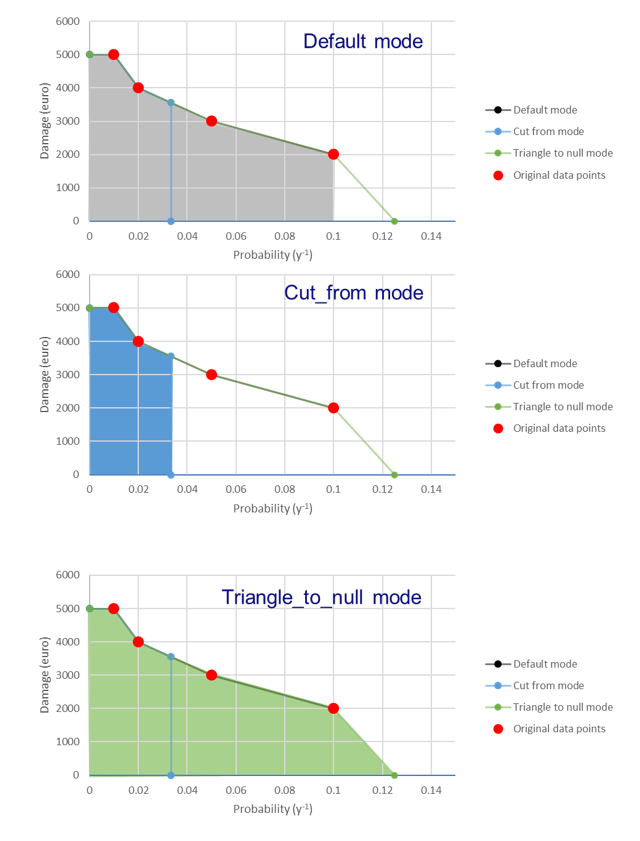

## Set up the parameters for the RA2CE analysis

Import the necessary RA2CE modules

In [ ]:
#RA2CE imports

from ra2ce.network.network_config_data.enums.road_type_enum import RoadTypeEnum
from ra2ce.network.network_config_data.network_config_data import (NetworkConfigData,NetworkSection,CleanupSection)
from ra2ce.network.network_config_data.enums.aggregate_wl_enum import AggregateWlEnum
from ra2ce.network.network_config_data.enums.source_enum import SourceEnum
from ra2ce.network.network_config_data.network_config_data import (NetworkConfigData,NetworkSection,HazardSection,)
from ra2ce.network.network_config_data.enums.aggregate_wl_enum import AggregateWlEnum
from ra2ce.network.network_config_data.network_config_data import (NetworkSection)
from ra2ce.ra2ce_handler import Ra2ceHandler
from ra2ce.analysis.damages.damages import AnalysisSectionDamages
from ra2ce.analysis.analysis_config_data.enums.analysis_damages_enum import AnalysisDamagesEnum
from ra2ce.analysis.analysis_config_data.enums.event_type_enum import EventTypeEnum
from ra2ce.analysis.analysis_config_data.enums.damage_curve_enum import DamageCurveEnum
from ra2ce.analysis.analysis_config_data.analysis_config_data import AnalysisConfigData
from ra2ce.analysis.analysis_config_data.enums.risk_calculation_mode_enum import RiskCalculationModeEnum
from ra2ce.network.network_config_data.enums.network_type_enum import NetworkTypeEnum

import ra2ce.network.networks_utils as nut
from ra2ce.network.network_config_data.enums.network_type_enum import NetworkTypeEnum
from ra2ce.network.network_config_data.enums.road_type_enum import RoadTypeEnum
from ra2ce.network.network_config_data.network_config_data import (NetworkConfigData,NetworkSection,CleanupSection,)
from ra2ce.network.network_wrappers.osm_network_wrapper.osm_network_wrapper import (OsmNetworkWrapper,)
from ra2ce.network.exporters.geodataframe_networkexporter import GeoDataFrameNetworkExporter
from ra2ce.network.exporters.multi_graph_network_exporter import MultiGraphNetworkExporter

In this example and for the analysis configuration, we use the Huizinga damage curve in combination with triangle_to_null_year risk calculation mode.

In [ ]:
network_section = NetworkSection(
    network_type=NetworkTypeEnum.DRIVE,
    source=SourceEnum.OSM_DOWNLOAD, #download the network from OSM 
    polygon=bbox_polygon, #introduce the study area's polygon that you made based on the extent of the flood maps above. 
    save_gpkg=True,
    road_types=[        #determine the level of detail you want to introduce to your road network. Mind that having more detail in a large area will slow down OSM download speed. 
        RoadTypeEnum.UNCLASSIFIED,
        RoadTypeEnum.RESIDENTIAL,
        RoadTypeEnum.TERTIARY,
        RoadTypeEnum.TERTIARY_LINK,
        RoadTypeEnum.SECONDARY,
        RoadTypeEnum.SECONDARY_LINK,
        RoadTypeEnum.PRIMARY,
        RoadTypeEnum.PRIMARY_LINK,
        RoadTypeEnum.TRUNK,
        RoadTypeEnum.MOTORWAY,
        RoadTypeEnum.MOTORWAY_LINK,
    ],
) 

cleanup_section = CleanupSection(
    segmentation_length=100 #specify segmentation length, cuts up the road network in segments of 'x' meters. We use 100 as default
)

hazard_section = HazardSection(
    hazard_map=[Path(file) for file in hazard_path.glob("*.tif")], # this finds the multiple flood maps in the hazard folder
    aggregate_wl = AggregateWlEnum.MEAN, #mean water level is used for damage analysis
    hazard_crs = "EPSG:28992", #Make sure your hazard map is in 4326
)

network_config_data = NetworkConfigData(
    root_path=root_dir,
    static_path=static_path,
    output_path=output_path,
    network=network_section,
    cleanup=cleanup_section,
    hazard=hazard_section
)
network_config_data.network.save_gpkg = True

graph,gdf = OsmNetworkWrapper.get_network_from_polygon(network_config_data, bbox_polygon)

# Export the graph
exporter = MultiGraphNetworkExporter(basename='base_graph', export_types=['gpkg', 'pickle'])
exporter.export(export_path=root_dir.joinpath('static','output_graph'), export_data=graph)

# Export the network
exporter = GeoDataFrameNetworkExporter(basename='base_network', export_types=['gpkg', 'pickle'])
exporter.export(export_path=root_dir.joinpath('static','output_graph'), export_data=gdf)

In [ ]:
center = [
    gdf_polygon['geometry'].centroid.y.mean(),
    gdf_polygon['geometry'].centroid.x.mean()
]

m = folium.Map(location=center,zoom_start=12, control_scale=True, tiles="cartodbpositron")

polygon_group = folium.FeatureGroup(name="Case boundary").add_to(m)
gdf_polygon.explore(m=polygon_group, style_kwds={'fillOpacity': 0.1, 'lineOpacity': 0.1}, tiles='CartoDB positron')
polygon_group.add_to(m)

network_group = folium.FeatureGroup(name="case network").add_to(m)
gdf.explore(m=network_group, color='black')
network_group.add_to(m)
folium.LayerControl().add_to(m)

m

## Create depth damage curves

Here you can create your own depth damage curves. Before creating the damage curves its good to have an idea about what your road network looks like

What different types of roads and lanes are in the input data? We need to incorporate these in the manual damage functions that we will introduce later

In [ ]:
print("Road Types: ",gdf["highway"].unique())
print("Lane Types: ",gdf["lanes"].unique())

## Input the construction costs and maximum damages per road type

Here, we will load a pre-made csv. If you set up your own use case, you need to make a similar csv and replace the vlaues with your own values of road types, number of lanes and their respective construction costs

In [ ]:
input_data_path = root_dir.joinpath("input_data","damage_functions","all_road_types")
pd.read_csv(input_data_path.joinpath("max_damage_road_types.csv"), delimiter=";")

## Create manual damage curve input and create a csv from it

Here, we will load a pre-made csv. If you set up your own use case, you need to make a similar csv and replace the vlaues with your own values of cm depth and %damage

In [ ]:
pd.read_csv(input_data_path.joinpath("hazard_severity_damage fraction.csv"), delimiter=";")

Set the analysis parameters. Read the comments for explanation on each parameter or analyse AnalysisSectionDamage in the RA2CE base code

In [19]:
#specify the parameters for the damage analysis 
damages_analysis = [AnalysisSectionDamages( 
    
  name = 'RP_damages_MAN', #specify the name for your analysis

  analysis= AnalysisDamagesEnum.DAMAGES, #If you do damage analysis you should choose damages here

  event_type = EventTypeEnum.RETURN_PERIOD, #We can specify return period based and event based here. If you have multiple flood maps with return periods, put return period. 

  damage_curve = DamageCurveEnum.MAN, #Set the damage curve you would like to use. HZ and OsDamage are built-in damage curves. For manual damage curves you need to add more data yourself. See the manual damage curve examples. 

  risk_calculation_mode = RiskCalculationModeEnum.TRIANGLE_TO_NULL_YEAR, # Other options: #RiskCalculationModeEnum.CUT_FROM_YEAR, #RiskCalculationModeEnum.DEFAULT, 

  risk_calculation_year = 5,#For Triangle_to_null_year: this parameters is the year at which the damages are assumed to be zero. You can only put a number below your lowest RP.
                            #For cut_from_mode: this parameter is the year below which we assume no damage (usually because of protection or adaptation measures). For this mode you need to specify a number above your lowest provided RP. 
                            #For the default mode this parameter is not used
  
  #save your outputs as both csv and gpkg in the output folder                          
  save_csv=True,
  save_gpkg=True
  )]

analysis_config_data = AnalysisConfigData(
    analyses= damages_analysis,
    root_path= root_dir,
    output_path= output_path,
    )

analysis_config_data = AnalysisConfigData(analyses=damages_analysis, root_path=root_dir, output_path=output_path)
analysis_config_data.input_path = root_dir.joinpath("input_data")

##### Run RA2CE with the configuration parameters

In [ ]:
Ra2ceHandler.run_with_config_data(
    network_config_data, analysis_config_data)

## Visualising the results

Let's find the results that RA2CE outputted to your output folder

In [ ]:
analysis_output_path = root_dir.joinpath("output","damages")
damage_gdf = gpd.read_file(analysis_output_path.joinpath('RP_damages_MAN_link_based_segmented.gpkg'))
damage_gdf.head() #show the origins

Select the return period to show with the format *dam_RP<return_period>_HZ*

In [21]:
return_period_damage = 'dam_RP100_al'

Show damages for the selected return period.

In [ ]:
null_mask = damage_gdf[return_period_damage].isnull()
damage_gdf.loc[null_mask, return_period_damage] = damage_gdf.loc[null_mask, return_period_damage].replace({np.nan: 0})

colormap = LinearColormap(['yellow', 'orange', 'red'], vmin=0, vmax=damage_gdf[return_period_damage].max(), caption=return_period_damage)

# Create a Folium map centered around the mean of the geometry
center = [damage_gdf['geometry'].centroid.y.mean(), damage_gdf['geometry'].centroid.x.mean()]
m = folium.Map(location=center, zoom_start=12, control_scale=True, tiles="CartoDB dark_matter")

# Create the color strip legend with white font color
colormap.caption = return_period_damage
colormap.add_to(m)
colormap._repr_html_ = colormap._repr_html_().replace(
    'background-color: #000', 'background-color: #000; color: #000'
)

# Add edges to the map
for idx, row in damage_gdf.iterrows():
    color = 'darkgray' if row[return_period_damage] == 0 else colormap(row[return_period_damage])
    
    # Extracting coordinates from LineString
    coordinates = [(coord[1], coord[0]) for coord in row['geometry'].coords]

    # Create a popup with data
    popup_content = f"<strong>{return_period_damage}:</strong> {row[return_period_damage]}"
    popup = folium.Popup(popup_content, max_width=300)
    
    folium.PolyLine(
        locations=coordinates,
        color=color,
        weight=2,
        opacity=1,
        popup=popup
    ).add_to(m)

# Add colormap to the map
colormap.add_to(m)

# Display the map
m

Show the flood risk for the included flood maps and return periods. The attribute name is in this format: *risk_HZ*

Keep in mind that , during the analysis we put our risk calculation year as 5 and our risk calculation method as TRIANGLE_TO_NULL_YEAR. Therefore the damages are extrapolated to 0 from RP5 flood map 

In [ ]:
damage_gdf.explore(column="risk_al", cmap="viridis_r", scheme='quantiles', tiles="CartoDB dark_matter")

What is the total risk according to this method?

In [ ]:
total_damage = damage_gdf["risk_al"].sum()
valuta = "Euro"

print(f"Total damages from this hazard on the analyzed road network according to the specified method is: {round(total_damage, 0)} {valuta}")